<a href="https://colab.research.google.com/github/srush/Triton-Puzzles/blob/main/Triton-Puzzles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Triton Puzzles

Programming for accelerators such as GPUs is critical for modern AI systems.
This often means programming directly in proprietary low-level languages such as CUDA. [Triton](https://github.com/openai/triton/) is an alternative open-source language that allows you to code at a higher-level and compile to accelerators like GPU.

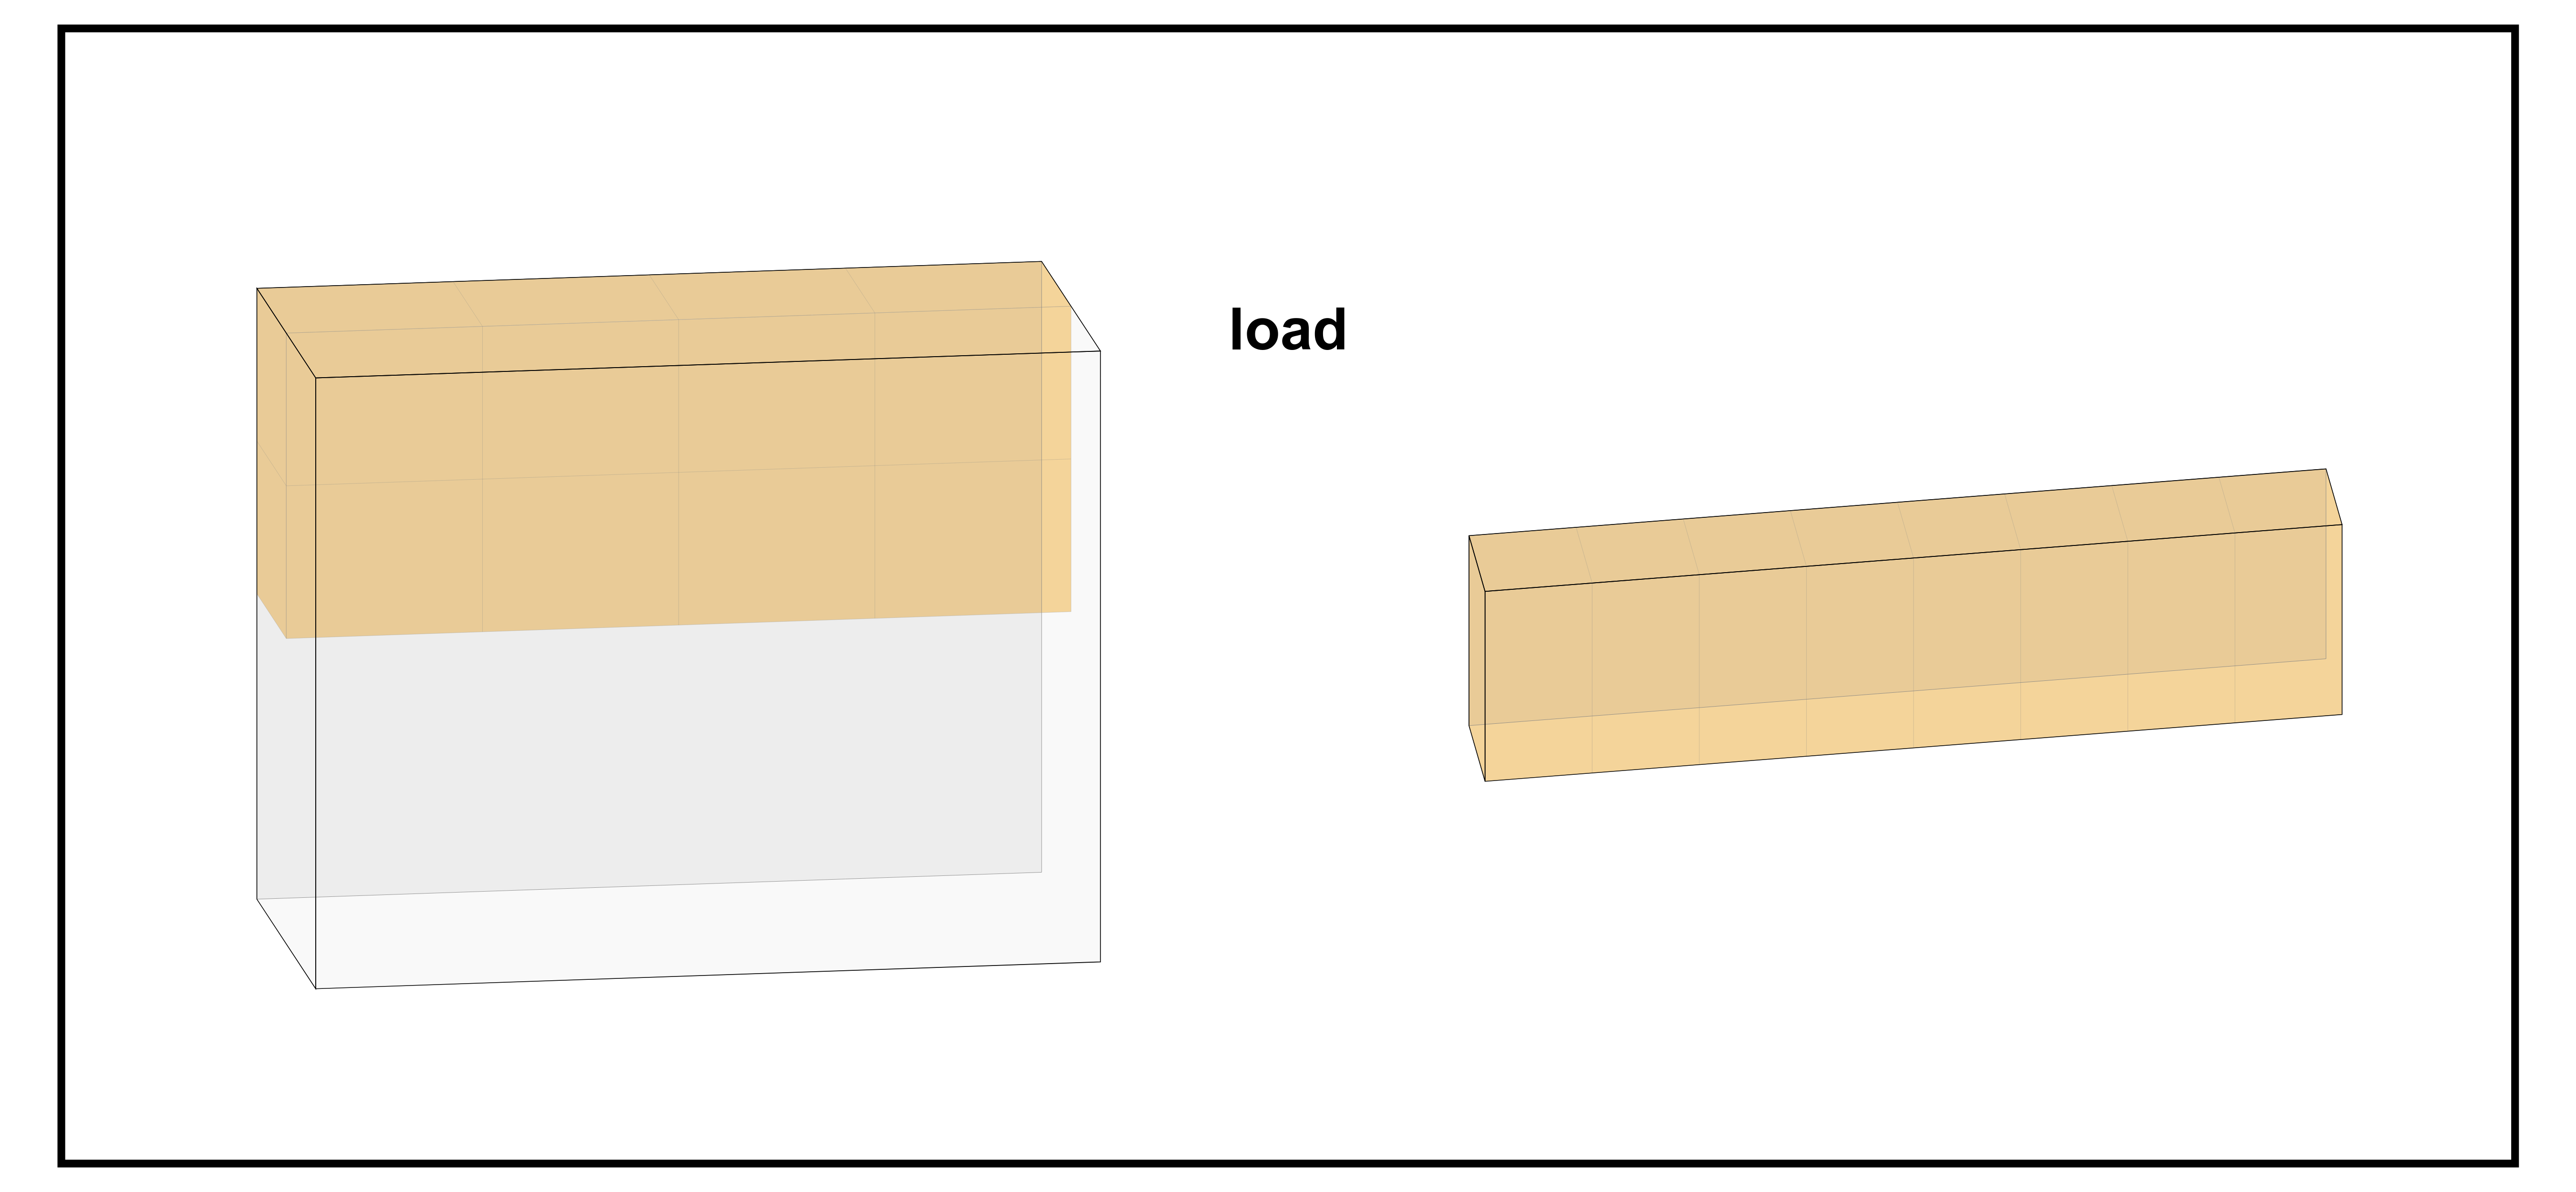

Coding for Triton is very similar to Numpy and PyTorch in both syntax and semantics. However, as a lower-level language there are a lot of details that you need to keep track of. In particular, one area that learners have trouble with is memory loading and storage which is critical for speed on low-level devices.

This set is puzzles is meant to teach you how to use Triton from first principles in an interactive fashion. You will start with trivial examples and build your way up to real algorithms like Flash Attention and Quantized neural networks. These puzzles **do not** need to run on GPU since they use a Triton interpreter.




In [1]:
# %%capture
# # Only need to run the first time.
# # Works with latest triton. Sorry, this takes a minute to install.
# !apt install libcairo2-dev pkg-config python3-dev
# !pip install jaxtyping
# !pip install git+https://github.com/Deep-Learning-Profiling-Tools/triton-viz@v1.1.1
# !pip install triton-3.1.0
# !pip install pycairo
# !export LC_ALL="en_US.UTF-8"
# !export LD_LIBRARY_PATH="/usr/lib64-nvidia"
# !export LIBRARY_PATH="/usr/local/cuda/lib64/stubs"
# !ldconfig /usr/lib64-nvidia

In [2]:
# %pip install git+https://github.com/Deep-Learning-Profiling-Tools/triton-viz@v1.1.1

In [3]:
# %pip install --upgrade pip

In [4]:
import torch
import triton
from torch import Tensor
import triton.language as tl
import jaxtyping
from jaxtyping import Float32, Int32

In [5]:
print(torch.__version__)
print(triton.__version__)

2.6.0+cu126
3.2.0


In [6]:
# @title Setup

import triton_viz
import inspect
from triton_viz.interpreter import record_builder

def test(puzzle, puzzle_spec, nelem={}, B={"B0": 32}, viz=True):
    B = dict(B)
    if "N1" in nelem and "B1" not in B:
        B["B1"] = 32
    if "N2" in nelem and "B2" not in B:
        B["B2"] = 32

    triton_viz.interpreter.record_builder.reset()
    torch.manual_seed(0)
    signature = inspect.signature(puzzle_spec)
    args = {}
    for n, p in signature.parameters.items():
        print(p)
        args[n + "_ptr"] = ([d.size for d in p.annotation.dims], p)
    args["z_ptr"] = ([d.size for d in signature.return_annotation.dims], None)

    tt_args = []
    for k, (v, t) in args.items():
        tt_args.append(torch.rand(*v) - 0.5)
        if t is not None and t.annotation.dtypes[0] == "int32":
            tt_args[-1] = torch.randint(-100000, 100000, v)
    grid = lambda meta: (triton.cdiv(nelem["N0"], meta["B0"]),
                         triton.cdiv(nelem.get("N1", 1), meta.get("B1", 1)),
                         triton.cdiv(nelem.get("N2", 1), meta.get("B2", 1)))

    #for k, v in args.items():
    #    print(k, v)
    triton_viz.trace(puzzle)[grid](*tt_args, **B, **nelem)
    z = tt_args[-1]
    tt_args = tt_args[:-1]
    z_ = puzzle_spec(*tt_args)
    match = torch.allclose(z, z_, rtol=1e-3, atol=1e-3)
    print("Results match:",  match)
    failures = False
    if viz:
        failures = triton_viz.launch()
    if not match or failures:
        print("Invalid Access:", failures)
        print("Yours:", z)
        print("Spec:", z_)
        print(torch.isclose(z, z_))
        return
    # PUPPIES!
    from IPython.display import HTML
    import random
    print("Correct!")
    pups = [
    "2m78jPG",    "pn1e9TO",    "MQCIwzT",    "udLK6FS",    "ZNem5o3",    "DS2IZ6K",    "aydRUz8",    "MVUdQYK",
    "kLvno0p",    "wScLiVz",    "Z0TII8i",    "F1SChho",    "9hRi2jN",    "lvzRF3W",    "fqHxOGI",    "1xeUYme",
    "6tVqKyM",    "CCxZ6Wr",    "lMW0OPQ",    "wHVpHVG",    "Wj2PGRl",    "HlaTE8H",   "k5jALH0",    "3V37Hqr",
    "Eq2uMTA",    "Vy9JShx",    "g9I2ZmK",    "Nu4RH7f",    "sWp0Dqd",    "bRKfspn",    "qawCMl5",    "2F6j2B4",
    "fiJxCVA",    "pCAIlxD",    "zJx2skh",    "2Gdl1u7",    "aJJAY4c",    "ros6RLC",    "DKLBJh7",    "eyxH0Wc",
    "rJEkEw4"]
    return HTML("""
    <video alt="test" controls autoplay=1>
        <source src="https://openpuppies.com/mp4/%s.mp4"  type="video/mp4">
    </video>
    """%(random.sample(pups, 1)[0]))

/home/vvy/Desktop/repos/NeuroForge/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# %pip install pycairo

## Introduction

To begin with, we will only use `tl.load` and `tl.store` in order to build simple programs.

Here's an example of load. It takes an `arange` over the memory. By default the indexing of torch tensors with column, rows, depths or right-to-left. It also takes in a mask as the second argument. Mask is critically important because all shapes in Triton need to be powers of two.

In [8]:
@triton.jit
def demo(x_ptr):
    range = tl.arange(0, 8)
    # print works in the interpreter
    print(range); print(x_ptr)
    x = tl.load(x_ptr + range, range < 5, 0)
    print(x)

triton_viz.trace(demo)[(1, 1, 1)](x:=torch.randn(4, 3))
print(f"\n{x=}")
# triton_viz.launch()

[0 1 2 3 4 5 6 7]
[989218496]
[-0.8808472  -1.3841807   1.0506887  -0.5403269  -0.59917486  0.
  0.          0.        ]

x=tensor([[-0.8808, -1.3842,  1.0507],
        [-0.5403, -0.5992, -1.4915],
        [ 0.5286, -0.0385,  0.0226],
        [-2.2397, -0.6033, -2.7321]])


You can also use this trick to read in a 2d array.

In [9]:
@triton.jit
def demo(x_ptr):
    # i_range = tl.arange(0, 8)[:, None] # (8, 1)
    # j_range = tl.arange(0, 4)[None, :] # (1, 4)

    # print(i_range.__mul__(4).broadcast_to(8, 4))
    # print(j_range.broadcast_to(8, 4))
 
    # range = i_range * 4 + j_range
    range = tl.arange(0, 32).reshape(8, 4)

    print(f"{range=}", end="\n\n")

    # For entries where mask == True, Triton fetches from memory.
    # For entries where mask == False, Triton does not touch memory (avoids illegal/out-of-bounds loads) and instead writes 0 there.

    x = tl.load(x_ptr + range, )# (i_range < 8) & (j_range < 4), 0)

    print(f"{x=}")

triton_viz.trace(demo)[(1, 1, 1)](x:=torch.arange(4*4).reshape(4, 4))
print(f"\nrandn{x=}")
# triton_viz.launch()

range=array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11],
       [12, 13, 14, 15],
       [16, 17, 18, 19],
       [20, 21, 22, 23],
       [24, 25, 26, 27],
       [28, 29, 30, 31]], dtype=int32)

x=array([[                  0,                   1,                   2,
                          3],
       [                  4,                   5,                   6,
                          7],
       [                  8,                   9,                  10,
                         11],
       [                 12,                  13,                  14,
                         15],
       [           11699224,                 113,           994412704,
        2556105360422530934],
       [    129030433517424,     129030072116592,     129030072116656,
            129030072482992],
       [    129030072078320,            11702384,     129035201590832,
                   11664112],
       [           11698520,     129030072078368,                 256,

The `tl.store` function is quite similar. It allows you to write to a tensor.

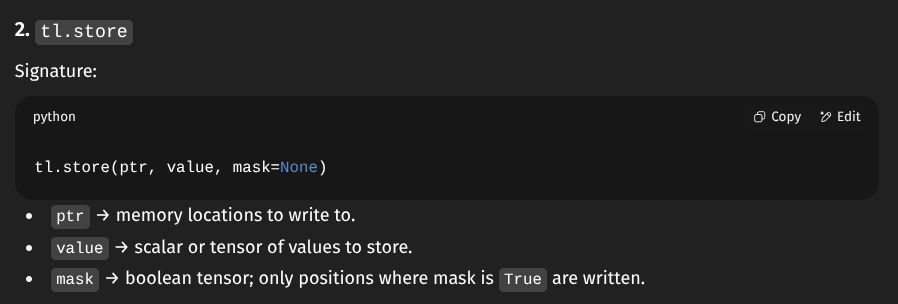

In [10]:
@triton.jit
def demo(z_ptr):
    range = tl.arange(0, 8) # (8,)
    print(f"{range=}")
    z = tl.store(z_ptr + range, 10, range < 7)
    # print(z)

z = torch.ones(4, 3)
print(f"\n{z=}")
triton_viz.trace(demo)[(1, 1, 1)](z)
print(z)
# triton_viz.launch()


z=tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])
range=array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int32)
tensor([[10., 10., 10.],
        [10., 10., 10.],
        [10.,  1.,  1.],
        [ 1.,  1.,  1.]])


You can only load in relatively small `blocks` at a time in Triton. to work with larger tensors you need to use a program id axis to run multiple blocks in parallel. Here is an example with one program axis with 3 blocks. You can use the visualizer to scroll over it.

In [11]:
@triton.jit
def demo(x_ptr):
    pid = tl.program_id(0)
    print(f"Program ID: {pid*8}")
    range = tl.arange(0, 8) + pid * 8 # will cover 8*3 elements with indexes (0, 7), (8, 15), (16, 23)
    print(f"{range=}")
    x = tl.load(x_ptr + range, range < 20, other=-1) # but allow only < 20
    print("Print for each", pid, x, end="\n\n")

x = torch.randn(2, 4, 4); print(f"Input: {x}\n{x.numel()}\n")
triton_viz.trace(demo)[(3, 1, 1)](x)
# triton_viz.launch()

Input: tensor([[[ 0.3060,  2.2494,  0.7946, -1.2156],
         [ 0.4781,  1.6557, -0.2134, -1.2385],
         [-0.7526, -0.2914, -1.4301,  0.3680],
         [ 0.2534, -0.4132,  0.7090, -0.4793]],

        [[ 1.6756, -0.9737,  1.7021, -0.2078],
         [ 1.9831,  0.8800,  0.0471, -0.1984],
         [ 0.8351, -1.5752,  0.5975,  0.0170],
         [-0.4381,  0.0696,  0.9282,  1.0657]]])
32

Program ID: [0]
range=array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int32)
Print for each [0] [ 0.30602598  2.249386    0.79461    -1.215632    0.4781278   1.655672
 -0.21338286 -1.2385333 ]

Program ID: [8]
range=array([ 8,  9, 10, 11, 12, 13, 14, 15], dtype=int32)
Print for each [1] [-0.75258106 -0.29137018 -1.4300646   0.3679596   0.25342548 -0.4132018
  0.70904225 -0.4793449 ]

Program ID: [16]
range=array([16, 17, 18, 19, 20, 21, 22, 23], dtype=int32)
Print for each [2] [ 1.6756085 -0.9737449  1.7021239 -0.2077766 -1.        -1.
 -1.        -1.       ]



See the [Triton Docs](https://triton-lang.org/main/index.html) for further information.

## Puzzle 1: Constant Add

Add a constant to a vector. Uses one program id axis. Block size `B0` is always the same as vector `x` with length `N0`.


$$z_i = 10 + x_i \text{ for } i = 1\ldots N_0$$


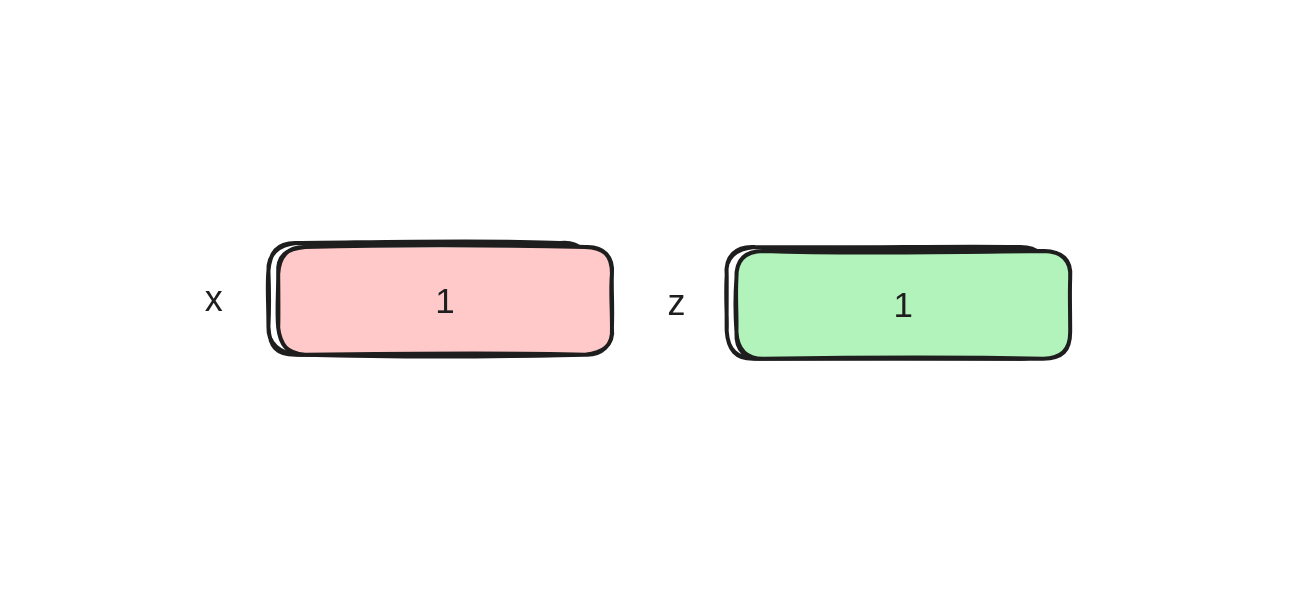

In [12]:
def add_spec(x: Float32[Tensor, "32"]) -> Float32[Tensor, "32"]:
    "This is the spec that you should implement. Uses typing to define sizes."
    return x + 10.

@triton.jit
def add_kernel(
    x_ptr, # input pointer
    z_ptr, # output pointer
    N0,    # length of input & output # 32
    B0: tl.constexpr # block size     # 32
):
    # print(f"{x_ptr=}, {z_ptr=}, {N0=}, {B0=}")
    col_idx = tl.arange(0, B0)    # [0, 1, 2, ..., 31]
    x = tl.load(x_ptr + col_idx)  #
    # print(f"{col_idx=}\n")
    # print(f"{x=}\n\n")
    # Finish me!
    z = x + 10.
    tl.store(z_ptr + col_idx, z)

test(add_kernel, add_spec, nelem={"N0": 32}, viz=False)

x: jaxtyping.Float32[Tensor, '32']
Results match: True
Correct!


## Puzzle 2: Constant Add Block

Add a constant to a vector. Uses one program block axis (no `for` loops yet). Block size `B0` is now smaller than the shape vector `x` which is `N0`.


$$z_i = 10 + x_i \text{ for } i = 1\ldots N_0$$



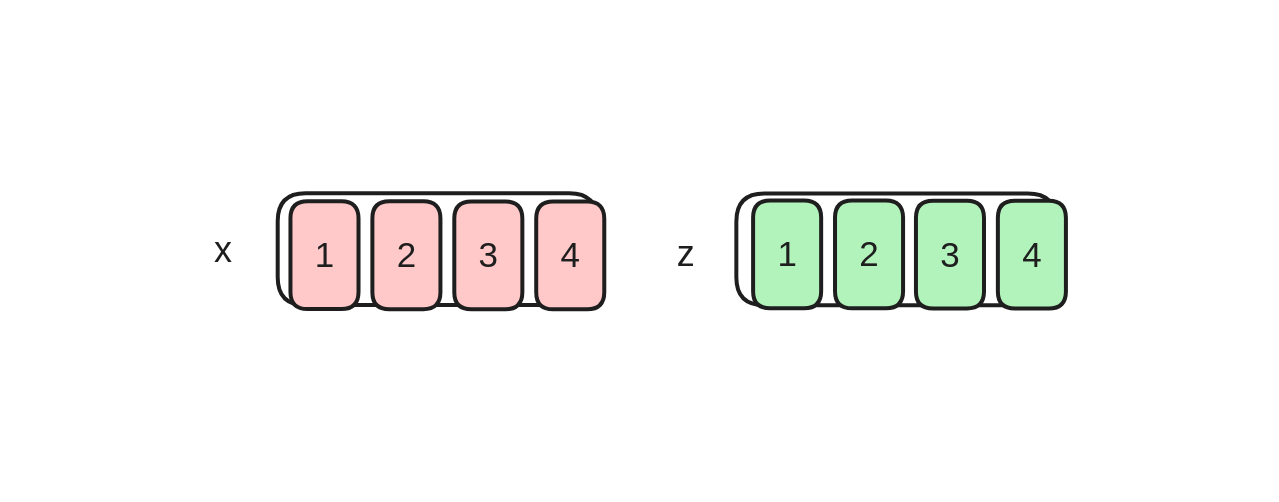

In [13]:
def add2_spec(x: Float32[Tensor, "200"]) -> Float32[Tensor, "200"]:
    return x + 10.

@triton.jit
def add_mask2_kernel(
    x_ptr, z_ptr, 
    N0, # 200 # length of input and output
    B0: tl.constexpr # 32 # block size
):
    # print(f"{x_ptr=}, {z_ptr=}, {N0=}, {B0=}")
    # 1 BLOCK: [T0, T1, T2, T3, T4, T5, T6]
    # Like this there are 32 BLOCKS
    pid = tl.program_id(0)
    col_idx = tl.arange(0, B0) + pid * B0 # [0, ..., 31] + 0...6 * 32 => [0:31, 32:63, 64:95, 96:127, 128:159, 160:191, 192:223]
    mask = col_idx < N0
    x = tl.load(x_ptr + col_idx, mask, other=0)
    z = x + 10
    tl.store(z_ptr + col_idx, z, mask)
    return z_ptr

test(add_mask2_kernel, add2_spec, nelem={"N0": 200}, viz=False)

x: jaxtyping.Float32[Tensor, '200']
Results match: True
Correct!


## Puzzle 3: Outer Vector Add

Add two vectors.

Uses one program block axis. Block size `B0` is always the same as vector `x` length `N0`.
Block size `B1` is always the same as vector `y` length `N1`.


$$z_{j, i} = x_i + y_j\text{ for } i = 1\ldots B_0,\ j = 1\ldots B_1$$


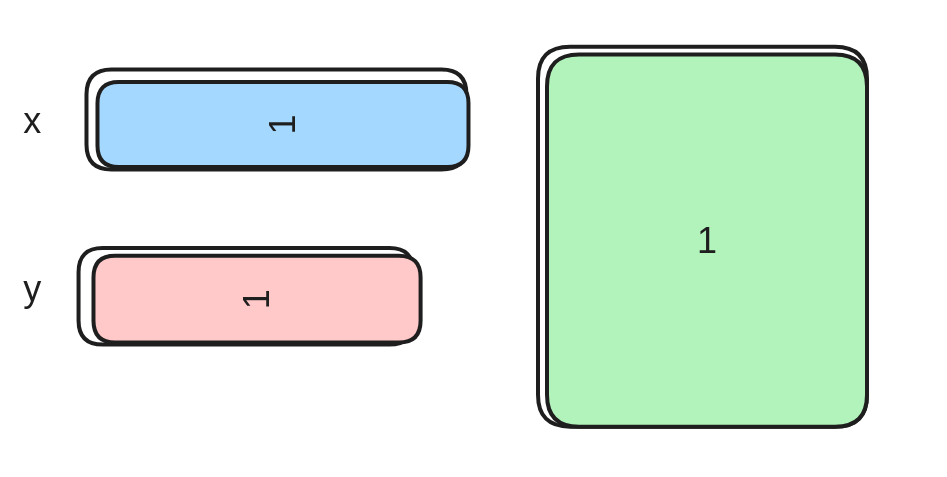

In [14]:
def add_vec_spec(x: Float32[Tensor, "32"], y: Float32[Tensor, "32"]) -> Float32[Tensor, "32 32"]:
    return x[None, :] + y[:, None]

@triton.jit
def add_vec_kernel(
    x_ptr, # input pointer
    y_ptr, # input pointer
    z_ptr, # output pointer
    N0, # length of x
    N1, # length of y
    B0: tl.constexpr, # block size of x; same as N0
    B1: tl.constexpr  # block size of y; same as N1
):
    # print(f"{N0=}, {N1=}, {B0=}, {B1=}")
    # pid = tl.program_id(0) # only one block; no need of this 
    col_xrange = tl.arange(0, B0) # [0, ..., B0]
    row_yrange = tl.arange(0, B1) # [0, ..., B1]
    z_range = row_yrange[:, None] * N0 + col_xrange[None, :] # (B1, B0) # A[row, col] <=> A[row * n_cols + col]
    x = tl.load(x_ptr + col_xrange, mask=col_xrange < N0) # (32,)
    y = tl.load(y_ptr + row_yrange, mask=row_yrange < N1) # (32,)
    z = x[None, :] + y[:, None] # (1, B0) + (B1, 1) => (B1, B0)=(32, 32)
    # print(f"{(z_ptr + z_range).shape}\n\n{z.shape}")
    tl.store(z_ptr + z_range, z, mask=z_range<N0*N1)
    return

test(add_vec_kernel, add_vec_spec, nelem={"N0": 32, "N1": 32}, viz=False)

x: jaxtyping.Float32[Tensor, '32']
y: jaxtyping.Float32[Tensor, '32']
Results match: True
Correct!


## Puzzle 4: Outer Vector Add Block

Add a row vector to a column vector.

Uses two program block axes. Block size `B0` is always less than the vector `x` length `N0`.
Block size `B1` is always less than vector `y` length `N1`.

$$z_{j, i} = x_i + y_j\text{ for } i = 1\ldots N_0,\ j = 1\ldots N_1$$


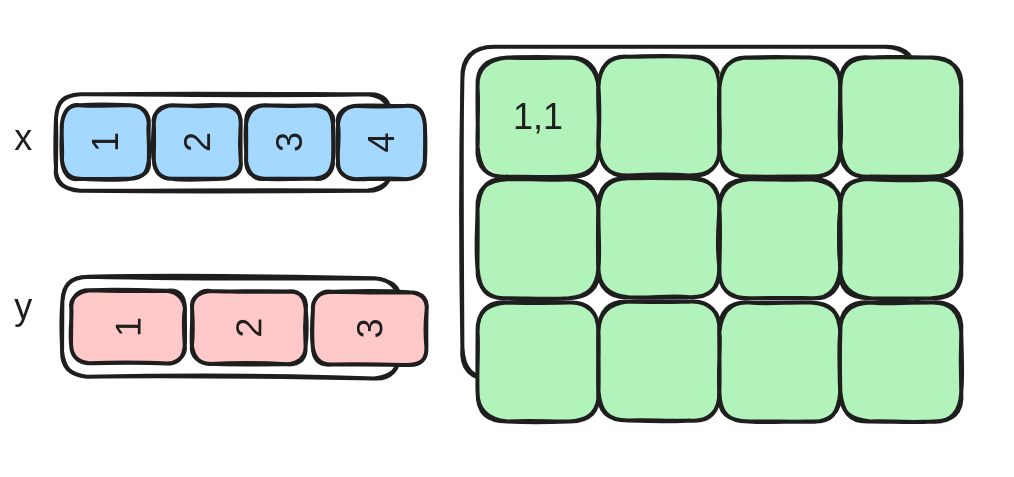

In [15]:
def add_vec_block_spec(x: Float32[Tensor, "100"], y: Float32[Tensor, "90"]) -> Float32[Tensor, "90 100"]:
    # (1, 100) + (90, 1) -> (90, 100) # (N1, N0)
    return x[None, :] + y[:, None]

@triton.jit
def add_vec_block_kernel(x_ptr, y_ptr, z_ptr, N0, N1, B0: tl.constexpr, B1: tl.constexpr): # col_xrange row_yrange
    xid = tl.program_id(0)
    yid = tl.program_id(1)
    # print(f"pid: {xid} {yid}")

    col_xrange = tl.arange(0, B0) + xid * B0
    row_yrange = tl.arange(0, B1) + yid * B1

    x = tl.load(x_ptr + col_xrange, mask=col_xrange<N0) # (B0,)
    y = tl.load(y_ptr + row_yrange, mask=row_yrange<N1) # (B1,)
    # print(f"\n{x=}, \n{y=}")

    z = x[None, :] + y[:, None] # (B1, B0)
    # print(f"pid: {xid} {yid} => \n{z}")
    zrange = row_yrange[:, None] * N0 + col_xrange[None, :] # (B1, B0) # (row, col) => (row * num_cols + col)
    tl.store(z_ptr + zrange, z, mask=(col_xrange[None, :]<N0) & (row_yrange[:, None] < N1))
    return

test(add_vec_block_kernel, add_vec_block_spec, nelem={"N0": 100, "N1": 90}) # BlockDim(4, 3, 1)

x: jaxtyping.Float32[Tensor, '100']
y: jaxtyping.Float32[Tensor, '90']
Results match: True
* Running on public URL: https://475ac2ebdf820e3173.gradio.live


Correct!


## Puzzle 5: Fused Outer Multiplication

Multiply a row vector to a column vector and take a relu.

Uses two program block axes. Block size `B0` is always less than the vector `x` length `N0`.
Block size `B1` is always less than vector `y` length `N1`.

$$z_{j, i} = \text{relu}(x_i \times y_j)\text{ for } i = 1\ldots N_0,\ j = 1\ldots N_1$$



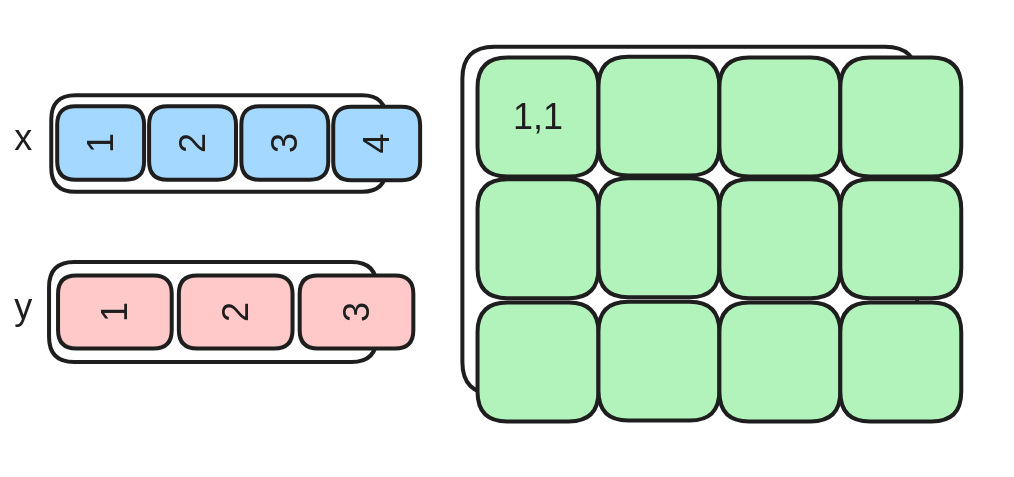

In [16]:
def mul_relu_block_spec(x: Float32[Tensor, "100"], y: Float32[Tensor, "90"]) -> Float32[Tensor, "90 100"]:
    return torch.relu(x[None, :] * y[:, None])

@triton.jit
def mul_relu_block_kernel(
    x_ptr, y_ptr, 
    z_ptr, 
    N0, N1, # input sizes
    B0: tl.constexpr, B1: tl.constexpr # block sizes
):
    xid = tl.program_id(0)
    yid = tl.program_id(1)

    col_xrange = tl.arange(0, B0) + xid * B0 # (B0,)
    row_yrange = tl.arange(0, B1) + yid * B1 # (B1,)

    x = tl.load(x_ptr + col_xrange, mask=col_xrange<N0)
    y = tl.load(y_ptr + row_yrange, mask=row_yrange<N1)

    z = tl.maximum(x[None, :] * y[:, None], 0)
    zrange = row_yrange[:, None] * N0 + col_xrange[None, :] # (B1, B0) # (row, col) => (row * num_col + col)
    tl.store(z_ptr + zrange, z, mask=(col_xrange[None, :] < N0) & (row_yrange[:, None] < N1))
    return

test(mul_relu_block_kernel, mul_relu_block_spec, nelem={"N0": 100, "N1": 90})
# (z_ptr + zrange).shape=[constexpr[32], constexpr[32]], 
# z.shape=[constexpr[32]], 
# ((col_xrange < N0) & (row_yrange < N1)).shape=[constexpr[32]], 
# zrange.shape=[constexpr[32], constexpr[32]]

x: jaxtyping.Float32[Tensor, '100']
y: jaxtyping.Float32[Tensor, '90']
Results match: True
* Running on public URL: https://891a5a7c996204e010.gradio.live


Correct!


## Puzzle 6: Fused Outer Multiplication - Backwards


Backwards of a function that multiplies a matrix with a row vector and take a relu.

Uses two program blocks. Block size `B0` is always less than the vector `x` length `N0`.
Block size `B1` is always less than vector `y` length `N1`. Chain rule backward `dz`
is of shape `N1` by `N0`

$$f(x, y) = \text{relu}(x_i \times y_j)\text{ for } i = 1\ldots N_0,\ j = 1\ldots N_1$$

$$dx_{i, j} = f_x'(x, y)_{i, j} \times dz_{i,j}$$

In [17]:
@torch.no_grad()
def my_torch_backward(
    x: Float32[Tensor, "90 100"], y: Float32[Tensor, "90"],
    dz: Float32[Tensor, "90 100"]
) -> Float32[Tensor, "90 100"]:
    x = x.clone()
    y = y.clone()

    dL_dh = ((x * y[:, None]) > 0).float() * dz.clone()
    dL_dx = dL_dh * y[:, None]
    return dL_dx

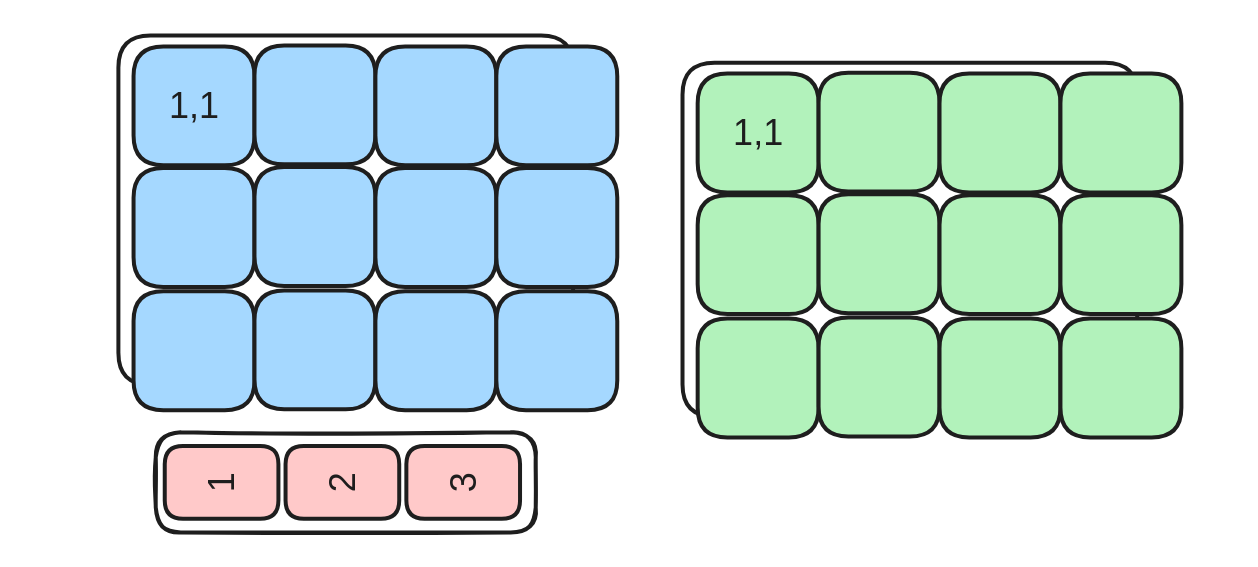

In [18]:
def mul_relu_block_back_spec(x: Float32[Tensor, "90 100"], y: Float32[Tensor, "90"],
                             dz: Float32[Tensor, "90 100"]) -> Float32[Tensor, "90 100"]:
    x = x.clone()
    y = y.clone()
    x = x.requires_grad_(True)
    y = y.requires_grad_(True)

    h = x * y[:, None]
    z = torch.relu(h)

    z.backward(dz)
    dx = x.grad
    my_dx = my_torch_backward(x, y, dz)
    torch.testing.assert_close(dx, my_dx)
    return dx

@triton.jit
def mul_relu_block_back_kernel(
    x_ptr,  # input pointer # x: (N1, N0)
    y_ptr,  # input pointer # y: (N1,)
    dz_ptr, # output_grad pointer # dz: (N1, N0)
    dx_ptr, # input_grad pointer # dx: (N1, N0)
    N0,     # number of rows
    N1,     # number of columns
    B0: tl.constexpr,
    B1: tl.constexpr
):
    pid_0 = tl.program_id(0)
    pid_1 = tl.program_id(1)

    col_xrange = tl.arange(0, B0) + pid_0 * B0 # (B0,)
    row_yrange = tl.arange(0, B1) + pid_1 * B1 # (B1,)

    # (row, col) => (row * num_cols + col)
    offsets = row_yrange[:, None] * N0 + col_xrange[None, :]    # (B1, B0)
    offsets_mask = (col_xrange[None, :] < N0) & (row_yrange[:, None] < N1) # (B1, B0)

    x = tl.load(x_ptr + offsets, mask=offsets_mask)
    y = tl.load(y_ptr + row_yrange, mask=row_yrange<N1)
    dL_dz = tl.load(dz_ptr + offsets, mask=offsets_mask)
    
    dL_dh = ((x * y[:, None]) > 0) * dL_dz
    dL_dx = dL_dh * y[:, None]

    tl.store(dx_ptr + offsets, value=dL_dx, mask=offsets_mask)
    return

test(mul_relu_block_back_kernel, mul_relu_block_back_spec, nelem={"N0": 100, "N1": 90}) # DimGrid(4, 3, 1)

x: jaxtyping.Float32[Tensor, '90 100']
y: jaxtyping.Float32[Tensor, '90']
dz: jaxtyping.Float32[Tensor, '90 100']
Results match: True
* Running on public URL: https://5c10afe0ea758d80ea.gradio.live


Correct!


## Puzzle 7: Long Sum

Sum of a batch of numbers.

Uses one program blocks. Block size `B0` represents a range of batches of  `x` of length `N0`.
Each element is of length `T`. Process it `B1 < T` elements at a time.  

$$z_{i} = \sum^{T}_j x_{i,j} =  \text{ for } i = 1\ldots N_0$$

Hint: You will need a for loop for this problem. These work and look the same as in Python.

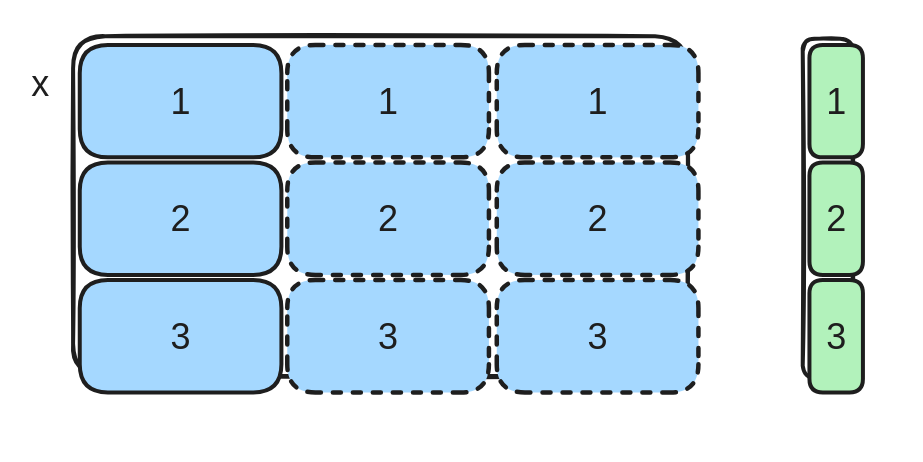

In [19]:
def sum_spec(x: Float32[Tensor, "4 200"]) -> Float32[Tensor, "4"]:
    return x.sum(1)

@triton.jit
def sum_kernel(
    x_ptr, # input pointer  # (N0, T)
    z_ptr, # output pointer # (N0,)
    N0,    # number of Batches
    N1, # NOT USED IGNORE
    T,     # length of each row i.e number of columns
    B0: tl.constexpr, # BLOCK ALONG BATCH DIMENSION
    B1: tl.constexpr  # BLOCK ALONG REDUCTION DIMENSION # sum over iter(B1) if B1_i < T only
):
    xid = tl.program_id(0)

    Bidx = tl.arange(0, B0) + xid * B0 # (B0=1,)
    z = tl.zeros((B0,), tl.float32) # (B0=1,)

    for j in tl.range(0, T, B1):
        Tidx = tl.arange(0, B1) + j # (B1,)

        # (row, col) => (row * num_cols + col)
        BT_idx = Bidx[:, None] * T + Tidx[None, :]
        xmask = (Bidx[:, None] < N0) & (Tidx[None, :] < T)

        x = tl.load(x_ptr + BT_idx, mask=xmask, other=0.0) # (B0=1, B1)
        z += x.sum(1) # (B0=1,)

    tl.store(z_ptr + Bidx, z, mask=Bidx < N0)
    return

test(sum_kernel, sum_spec, B={"B0": 1, "B1": 32}, nelem={"N0": 4, "N1": 32, "T": 200}) # DimGrid(4, 1, 1)

x: jaxtyping.Float32[Tensor, '4 200']
Results match: True
* Running on public URL: https://c7341b2560467f2daa.gradio.live


Correct!


## Puzzle 8: Long Softmax


Softmax of a batch of logits.

Uses one program block axis. Block size `B0` represents the batch of `x` of length `N0`.
Block logit length `T`.   Process it `B1 < T` elements at a time.  

$$z_{i, j} = \text{softmax}(x_{i,1} \ldots x_{i, T}) \text{ for } i = 1\ldots N_0$$

Note softmax needs to be computed in numerically stable form as in Python. In addition in Triton they recommend not using `exp` but instead using `exp2`. You need the identity

$$\exp(x) = 2^{\log_2(e) x}$$

Advanced: there one way to do this with 3 loops. You can also do it with 2 loops if you are clever. Hint: you will find this identity useful:

$$\exp(x_i - m) =  \exp(x_i - m/2 - m/2) = \exp(x_i - m/ 2) /  \exp(m/2) $$

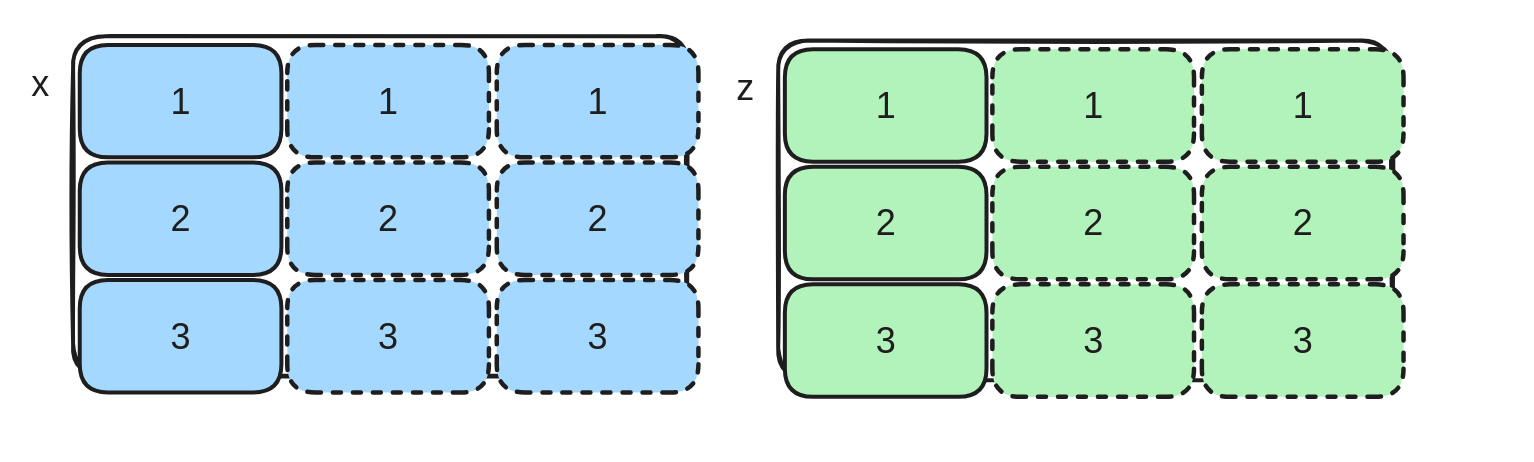

In [20]:
def softmax_spec(x: Float32[Tensor, "4 200"]) -> Float32[Tensor, "4 200"]:
    x_max = x.max(1, keepdim=True)[0] # (4, 1)
    x = x - x_max # (4, 200)
    x_exp = x.exp() # (4, 200)
    return x_exp / x_exp.sum(1, keepdim=True) # (4, 200)

LOG2_E = 1.44269504

# NAIVE VERSION -- 3 for loops
@triton.jit
def softmax_kernel(
    x_ptr, # input pointer
    z_ptr, # output pointer
    N0,    # number of rows
    N1, # NOT USED IGNORE
    T,     # length of each row; number of columns
    B0: tl.constexpr, # block size along batch dimension
    B1: tl.constexpr
):
    pid_0 = tl.program_id(0)

    Bidx = tl.arange(0, B0) + pid_0 * B0 # (B0=1,)
    
    # find max
    x_max = tl.full((B0,), value=float("-inf"), dtype=tl.float32) # (B0=1,)
    for j in tl.range(0, T, B1): # [0, B1, 2*B1, 3*B1, ...]
        # find column indices
        Tidx = tl.arange(0, B1) + j # (B1,)

        # (row, col) => (row * num_cols + col)
        BT_idx = Bidx[:, None] * T + Tidx[None, :] # (B0=1, B1)
        BT_mask = (Bidx[:, None] < N0) & (Tidx[None, :] < T) # (B0=1, B1)

        x = tl.load(x_ptr + BT_idx, mask=BT_mask) # (B0=1, B1)
        # find max
        x_max = tl.maximum(
            x_max,   # (B0=1,)
            x.max(1) # (B0=1,)
        ) # (B0=1,)

    # exp sum
    expf = lambda x: tl.exp2(LOG2_E * x)
    exp_sum = tl.zeros((B0,), dtype=tl.float32)
    for j in tl.range(0, T, B1):
        # find column indices
        Tidx = tl.arange(0, B1) + j # (B1,)

        # (row, col) => (row * num_cols + col)
        BT_idx = Bidx[:, None] * T + Tidx[None, :] # (B0=1, B1)
        BT_mask = (Bidx[:, None] < N0) & (Tidx[None, :] < T) # (B0=1, B1)

        x = tl.load(x_ptr + BT_idx, mask=BT_mask) # (B0=1, B1)
        # compute sum
        exp_sum += expf(x - x_max[:, None]).sum(axis=1)

    # softmax -- normalization with exp_sum
    for j in tl.range(0, T, B1):
        # find column indices
        Tidx = tl.arange(0, B1) + j # (B1,)

        # (row, col) => (row * num_cols + col)
        BT_idx = Bidx[:, None] * T + Tidx[None, :] # (B0=1, B1)
        BT_mask = (Bidx[:, None] < N0) & (Tidx[None, :] < T) # (B0=1, B1)

        x = tl.load(x_ptr + BT_idx, mask=BT_mask) # (B0=1, B1)
        z = expf(x - x_max[:, None])/exp_sum[:, None] # (B0=1, B1)/(B0=1, 1)
        tl.store(z_ptr + BT_idx, z, BT_mask)
    return

# OPTIMIZED VERSION -- 2 loops
@triton.jit
def softmax_kernel(x_ptr, z_ptr, N0, N1, T, B0: tl.constexpr, B1: tl.constexpr):
    block_id_i = tl.program_id(0)
    off_i = block_id_i * B0 + tl.arange(0, B0)
    mask_i = off_i < N0

    exp_sum = tl.zeros([B0], dtype=tl.float32)
    x_max = tl.full([B0], -float("inf"), dtype=tl.float32)
    new_x_max = tl.full((B0,), -float("inf"), dtype=tl.float32)

    for id_j in tl.range(0, T, B1):
        off_j = id_j + tl.arange(0, B1)
        off_ij = off_i[:, None] * T + off_j[None, :]
        mask_j = off_j < T
        mask_ij = mask_i[:, None] & mask_j[None, :]
        x = tl.load(x_ptr + off_ij, mask=mask_ij)

        # exp(x-new_max)=exp(x-old_max+old_max-new_max)=exp(x-old_max)*exp(old_max-new_max)
        # This is called "online softmax"
        new_x_max = tl.maximum(x_max, tl.max(x, axis=1))
        new_exp_x = tl.exp2(LOG2_E * (x - new_x_max[:, None]))
        factor = tl.exp2(LOG2_E * (x_max - new_x_max))
        exp_sum = exp_sum * factor + tl.sum(new_exp_x, axis=1)
        x_max = new_x_max

    for id_j in tl.range(0, T, B1):
        off_j = id_j + tl.arange(0, B1)
        off_ij = off_i[:, None] * T + off_j[None, :]
        mask_j = off_j < T
        mask_ij = mask_i[:, None] & mask_j[None, :]
        x = tl.load(x_ptr + off_ij, mask=mask_ij)
        exp_x = tl.exp2(LOG2_E * (x - x_max[:, None]))
        z = exp_x / exp_sum[:, None]
        tl.store(z_ptr + off_ij, z, mask=mask_ij)
    return

test(softmax_kernel, softmax_spec, B={"B0": 1, "B1":32},
     nelem={"N0": 4, "N1": 32, "T": 200})

x: jaxtyping.Float32[Tensor, '4 200']
Results match: True
* Running on public URL: https://dc25d510d5b3ecf990.gradio.live


Correct!


## Puzzle 9: Simple FlashAttention

A scalar version of FlashAttention.

Uses zero programs. Block size `B0` represents `k` of length `N0`.
Block size `B0` represents `q` of length `N0`. Block size `B0` represents `v` of length `N0`.
Sequence length is `T`. Process it `B1 < T` elements at a time.  

$$z_{i} = \sum_{j} \text{softmax}(q_1 k_1, \ldots, q_T k_T)_j v_{j} \text{ for } i = 1\ldots N_0$$

This can be done in 1 loop using a similar trick from the last puzzle.

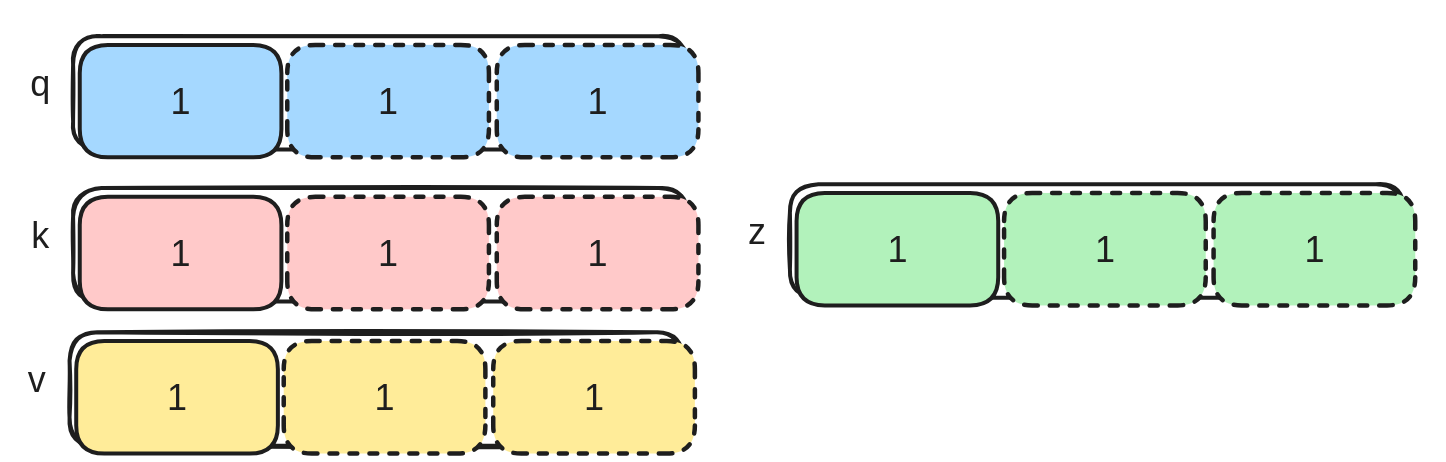

Flash Attention and Online Softmax

https://www.youtube.com/watch?v=gBMO1JZav44&t=425s&ab_channel=Jia-BinHuang

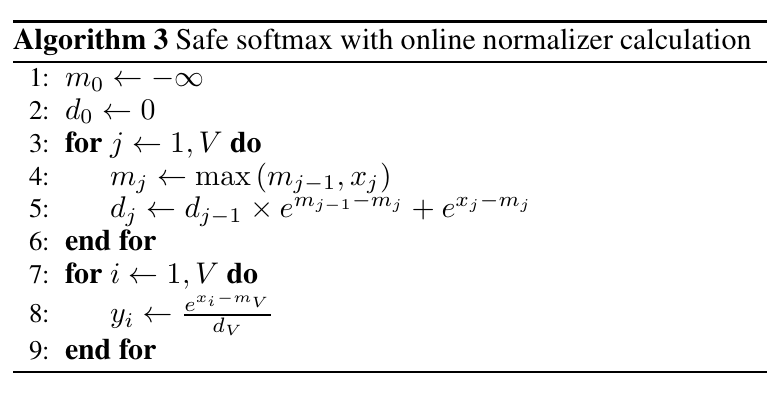

In [21]:
def flashatt_spec(q: Float32[Tensor, "200"], k: Float32[Tensor, "200"], v: Float32[Tensor, "200"]) -> Float32[Tensor, "200"]:
    x = q[:, None] * k[None, :]
    x_max = x.max(1, keepdim=True)[0]
    x = x - x_max
    x_exp = x.exp()
    soft =  x_exp  / x_exp.sum(1, keepdim=True)
    return (v[None, :] * soft).sum(1)

# QUESTION WORDING IS HORRIBLE, COULDN"T UNDETSTAND A THING
# DON"T KNOW IF THIS IS RIGHT SOLUTION, IT PASSES THE TESTS THOUGH
# DISCLOSURE: I AM NOT SURE IF THIS IS THE INTENDED SOLUTION
# TODO(VachanVY): Correct this
@triton.jit
def flashatt_kernel(
    q_ptr, # query pointer
    k_ptr, # key pointer
    v_ptr, # value pointer
    z_ptr, # output pointer
    N0, # NOT USED IGNORE
    T,    # length of q, k, v
    B0: tl.constexpr # block size
):
    expf = lambda x : tl.exp2(LOG2_E * x)

    Tidx = tl.arange(0, B0)
    mask_q = Tidx < T

    q = tl.load(q_ptr + Tidx, mask_q, other=0.0)
    k = tl.load(k_ptr + Tidx, mask_q, other=0.0)
    v = tl.load(v_ptr + Tidx, mask_q, other=0.0)
    
    att_scores = q[:, None] * k[None, :]  # Shape: (256, 256)
    
    valid_mask = (Tidx[:, None] < T) & (Tidx[None, :] < T)
    att_scores = tl.where(valid_mask, att_scores, float('-inf'))
    
    row_max = tl.max(att_scores, axis=1, keep_dims=True)
    att_scores = att_scores - row_max
    
    # mask again after subtraction to set invalid positions to -inf
    att_scores = tl.where(valid_mask, att_scores, float('-inf'))
    
    # Compute softmax
    att_exp = expf(att_scores)      
    att_sum = tl.sum(att_exp, axis=1, keep_dims=True)
    att_weights = att_exp / att_sum
    
    z = tl.sum(att_weights * v[None, :], axis=1)
    
    tl.store(z_ptr + Tidx, z, mask_q)
    return

test(flashatt_kernel, flashatt_spec, B={"B0":256},  # Use 256 instead of 200
     nelem={"N0": 200, "T": 200})

q: jaxtyping.Float32[Tensor, '200']
k: jaxtyping.Float32[Tensor, '200']
v: jaxtyping.Float32[Tensor, '200']
Results match: True


/home/vvy/Desktop/repos/NeuroForge/.venv/lib/python3.12/site-packages/triton/runtime/interpreter.py:417: RuntimeWarning: invalid value encountered in subtract
  return TensorHandle(op(lhs.data, rhs.data), lhs.dtype.scalar)
/home/vvy/Desktop/repos/NeuroForge/.venv/lib/python3.12/site-packages/triton/runtime/interpreter.py:417: RuntimeWarning: invalid value encountered in divide
  return TensorHandle(op(lhs.data, rhs.data), lhs.dtype.scalar)


* Running on public URL: https://fe4084f911fe1bb4d1.gradio.live


Correct!


## Puzzle 10: Two Dimensional Convolution

A batched 2D convolution.

Uses one program id axis. Block size `B0` represent the batches to process out of `N0`.
Image `x` is size is `H` by `W` with only 1 channel, and kernel `k` is size `KH` by `KW`.

$$z_{i, j, k} = \sum_{oj, ok} k_{oj,ok} \times x_{i,j + oj, k + ok} \text{ for } i = 1\ldots N_0$$



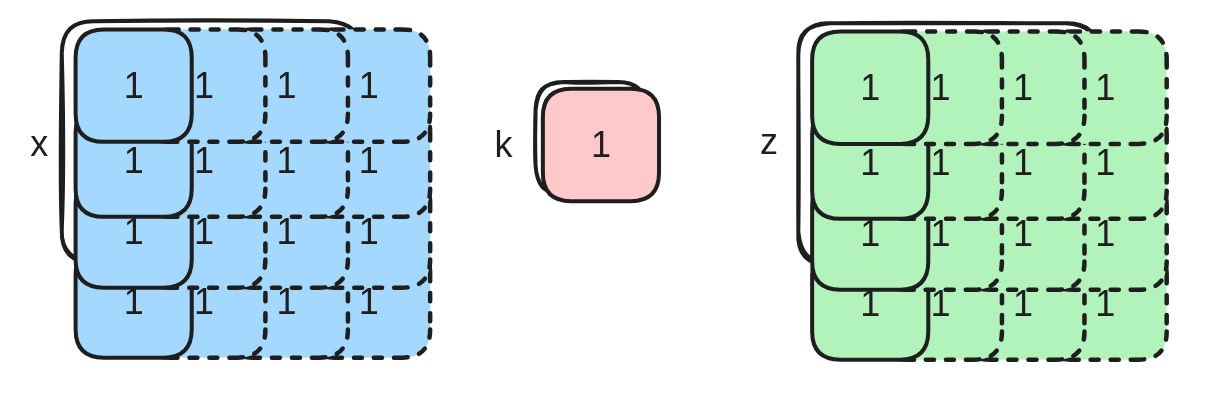

In [22]:
def conv2d_spec(x: Float32[Tensor, "4 8 8"], k: Float32[Tensor, "4 4"]) -> Float32[Tensor, "4 8 8"]:
    z = torch.zeros(4, 8, 8)
    x = torch.nn.functional.pad(x, (0, 4, 0, 4, 0, 0), value=0.0)
    # print(f"{x.shape=}") x.shape=torch.Size([4, 12, 12])
    for i in range(8):
        for j in range(8):
            # print(f"mul: {k[None, :, :].shape=}\t{x[:, i: i+4, j: j + 4].shape=}")
            # mul: k[None, :, :].shape=torch.Size([1, 4, 4])	x[:, i: i+4, j: j + 4].shape=torch.Size([4, 4, 4])
            z[:, i, j] = (k[None, :, :] * x[:, i: i+4, j: j + 4]).sum((1, 2)) # (1, 4, 4) * (4, 4, 4) => (C=4, H=4, W=4) ==.sum(1, 2)=> (C=4,)
    return z


@triton.jit
def conv2d_kernel(
    x_ptr, # (C, H, W)
    k_ptr, # (KH, KW)
    z_ptr, # (C, Ho, Wo)
    N0,    # 
    H, W, # IMAGE SIZE
    KH: tl.constexpr, KW: tl.constexpr, # KERNEL SIZE
    B0: tl.constexpr # block size along CHANNEL DIMENSION
):
    cid = tl.program_id(0)
    Cidx = (tl.arange(0, B0) + cid * B0)[:, None, None] # (B0, 1, 1)

    k_idx = tl.arange(0, KH)[:, None] * KW + tl.arange(0, KW)[None, :] # (KH, KW)
    k = tl.load(k_ptr + k_idx)[None] # (1, KH, KW)
    for h in tl.range(0, H):
        hidx = tl.arange(h, h + KH)[None, :, None] # (1, KH, 1)
        for w in tl.range(0, W):
            widx = tl.arange(w, w + KW)[None, None, :] # (1, 1, KW)

            # indexing
            # [ch, row, col] => [ch * num_rows * num_cols   +   row * num_cols  +  col]
            #           # (B0, 1, 1)                   # (1, KH, 1)                # (1, 1, KW)
            xrange = Cidx * H * W  +  hidx * W  +  widx # (B0, KH, KW)
            xmask = (Cidx < N0) & (hidx < H) & (widx < W)
            xhw = tl.load(x_ptr + xrange, mask=xmask, other=0.0) # (B0=1, KH, KW)

            # conv
            hz_idx = tl.arange(h, h + 1)[None, :, None]
            wz_idx = tl.arange(w, w+1)[None, None, :]

            zhw = (xhw * k).sum(1, keep_dims=True).sum(2, keep_dims=True) # (B0=1, 1, 1)
            zrange = Cidx * H * W  +  hz_idx * W  +  wz_idx # idx = [Cidx, h, w]
            zmask = (Cidx < N0) & (hz_idx < H) & (wz_idx < W)

            tl.store(z_ptr + zrange, zhw, mask=zmask)
    return

# got this correct on my first run! yey!
test(conv2d_kernel, conv2d_spec, B={"B0": 1}, nelem={"N0": 4, "H": 8, "W": 8, "KH": 4, "KW": 4}) # DimGrid(4, 1, 1) # 4 for 4 batches

x: jaxtyping.Float32[Tensor, '4 8 8']
k: jaxtyping.Float32[Tensor, '4 4']
Results match: True
* Running on public URL: https://0b50565d34290feb89.gradio.live


Correct!


## Puzzle 11: Matrix Multiplication

A blocked matrix multiplication.

Uses three program id axes. Block size `B2` represent the batches to process out of `N2`.
Block size `B0` represent the rows of `x` to process out of `N0`. Block size `B1` represent the cols of `y` to process out of `N1`. The middle shape is `MID`.

$$z_{i, j, k} = \sum_{l} x_{i,j, l} \times y_{i, l, k} \text{ for } i = 1\ldots N_2, j = 1\ldots N_0, k = 1\ldots N_1$$

You are allowed to use `tl.dot` which computes a smaller mat mul.

Hint: the main trick is that you can split a matmul into smaller parts.

$$z_{i, j, k} = \sum_{l=1}^{L/2} x_{i,j, l} \times y_{i, l, k} +  \sum_{l=L/2}^{L} x_{i,j, l} \times y_{i, l, k} $$


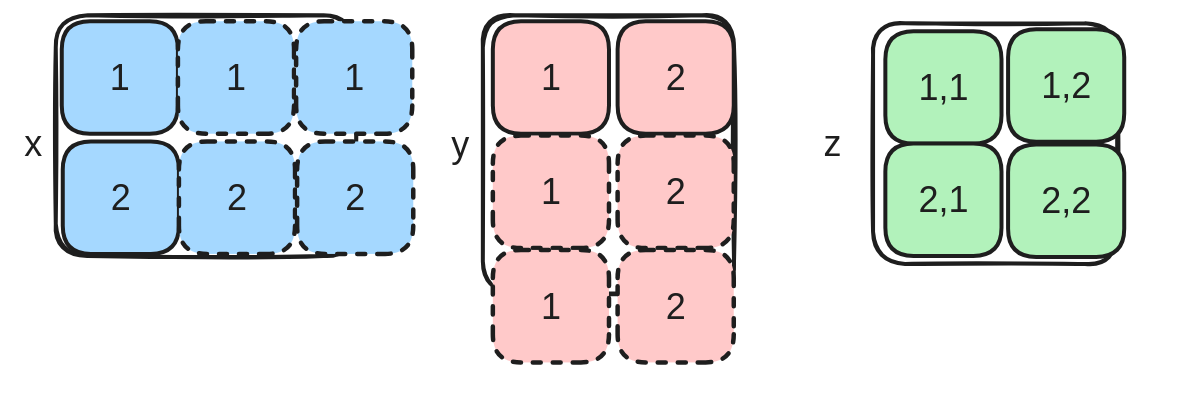

In [23]:
def dot_spec(x: Float32[Tensor, "4 32 32"], y: Float32[Tensor, "4 32 32"]) -> Float32[Tensor, "4 32 32"]:
    return x @ y

# (A , B, C ) @ (A , C , D) => (A, B, D)
# (N2,N0,MID) @ (N2,MID,N1) => (N2,N0,N1)
@triton.jit
def dot_kernel(
    x_ptr, # (N2,N0,MID)
    y_ptr, # (N2,MID,N1)
    z_ptr, # (N2,N0,N1)
    N0, # NUM ROWS      # 32
    N1, # NUM COLS      # 32
    N2, # NUM BATCHES   # 4
    MID,# MID DIMENSION # 32
    B0: tl.constexpr, # BLOCK SIZE ALONG N0 (rows)    # 16
    B1: tl.constexpr, # BLOCK SIZE ALONG N1 (cols)    # 16
    B2: tl.constexpr, # BLOCK SIZE ALONG N2 (batches) # 1
    B_MID: tl.constexpr # BLOCK SIZE ALONG MID        # 16
):
    # print(f"{N0=}, {N1=}, {N2=}, {MID=}, {B0=}, {B1=}, {B2=}, {B_MID=}")
    pid_0 = tl.program_id(0) # for col dim   # B1
    pid_1 = tl.program_id(1) # for row dim   # B0
    pid_2 = tl.program_id(2) # for batch dim # B2
    print(f"pid: {pid_0=} {pid_1=} {pid_2=}")

    bidx    = (tl.arange(0, B2) + pid_2 * B2)[:, None, None] # (B2, 1, 1)
    row_idx = (tl.arange(0, B0) + pid_1 * B0)[None, :, None] # (1, B0, 1)
    col_idx = (tl.arange(0, B1) + pid_0 * B1)[None, None, :] # (1, 1 ,B1)

    acc = tl.zeros((B2, B0, B1), dtype=tl.float32) # (B2, B0, B1)
    for mid in tl.range(0, MID, B_MID): # [0:B_MID, B_MID:2*B_MID, 2*B_MID:3*B_MID, ...]
        mid_idx = (tl.arange(0, B_MID) + mid) # (B_MID,)

        # [b, r, c] => b * num_rows * num_cols  +  r * num_cols  +  c
        xrange = bidx * N0 * MID  +  row_idx * MID  +  mid_idx[None, None, :]
        xmask = (bidx < N2) & (row_idx < N0) & (mid_idx[None, None, :] < MID)
        x = tl.load(x_ptr + xrange, mask=xmask) # (B2, B0, B_MID)

        # [b, r, c] => b * num_rows * num_cols  +  r * num_cols  +  c
        yrange = bidx * MID * N1  +  mid_idx[None, :, None] * N1 + col_idx
        ymask  = (bidx < N2) & (mid_idx[None, :, None] < MID) & (col_idx < N1)
        y = tl.load(y_ptr + yrange, mask=ymask) # (B2, B_MID, B1)

        # matmul
        acc += tl.dot(x, y) # (B2, B0, B_MID) @ (B2, B_MID, B1) => (B2, B0, B1)

    # [b, r, c] => b * num_rows * num_cols  +  r * num_cols  +  c
    zrange = bidx * N0 * N1 + row_idx * N1 + col_idx
    zmask = (bidx < N2) & (row_idx < N0) & (col_idx < N1)
    tl.store(z_ptr + zrange, value=acc, mask=zmask)


test(dot_kernel, dot_spec, B={"B0": 16, "B1": 16, "B2": 1, "B_MID": 16}, nelem={"N0": 32, "N1": 32, "N2": 4, "MID": 32}) # DimGrid(2, 2, 4)

x: jaxtyping.Float32[Tensor, '4 32 32']
y: jaxtyping.Float32[Tensor, '4 32 32']
pid: pid_0=array([0], dtype=int32) pid_1=array([0], dtype=int32) pid_2=array([0], dtype=int32)
pid: pid_0=array([0], dtype=int32) pid_1=array([0], dtype=int32) pid_2=array([1], dtype=int32)
pid: pid_0=array([0], dtype=int32) pid_1=array([0], dtype=int32) pid_2=array([2], dtype=int32)
pid: pid_0=array([0], dtype=int32) pid_1=array([0], dtype=int32) pid_2=array([3], dtype=int32)
pid: pid_0=array([0], dtype=int32) pid_1=array([1], dtype=int32) pid_2=array([0], dtype=int32)
pid: pid_0=array([0], dtype=int32) pid_1=array([1], dtype=int32) pid_2=array([1], dtype=int32)
pid: pid_0=array([0], dtype=int32) pid_1=array([1], dtype=int32) pid_2=array([2], dtype=int32)
pid: pid_0=array([0], dtype=int32) pid_1=array([1], dtype=int32) pid_2=array([3], dtype=int32)
pid: pid_0=array([1], dtype=int32) pid_1=array([0], dtype=int32) pid_2=array([0], dtype=int32)
pid: pid_0=array([1], dtype=int32) pid_1=array([0], dtype=int32) 

Correct!


In [ ]:
#       x   y   z
# pid: [0] [0] [0]
# pid: [0] [0] [1]
# pid: [0] [0] [2]
# pid: [0] [0] [3]
# pid: [0] [1] [0]
# pid: [0] [1] [1]
# pid: [0] [1] [2]
# pid: [0] [1] [3]
# pid: [1] [0] [0]
# pid: [1] [0] [1]
# pid: [1] [0] [2]
# pid: [1] [0] [3]
# pid: [1] [1] [0]
# pid: [1] [1] [1]
# pid: [1] [1] [2]
# pid: [1] [1] [3]

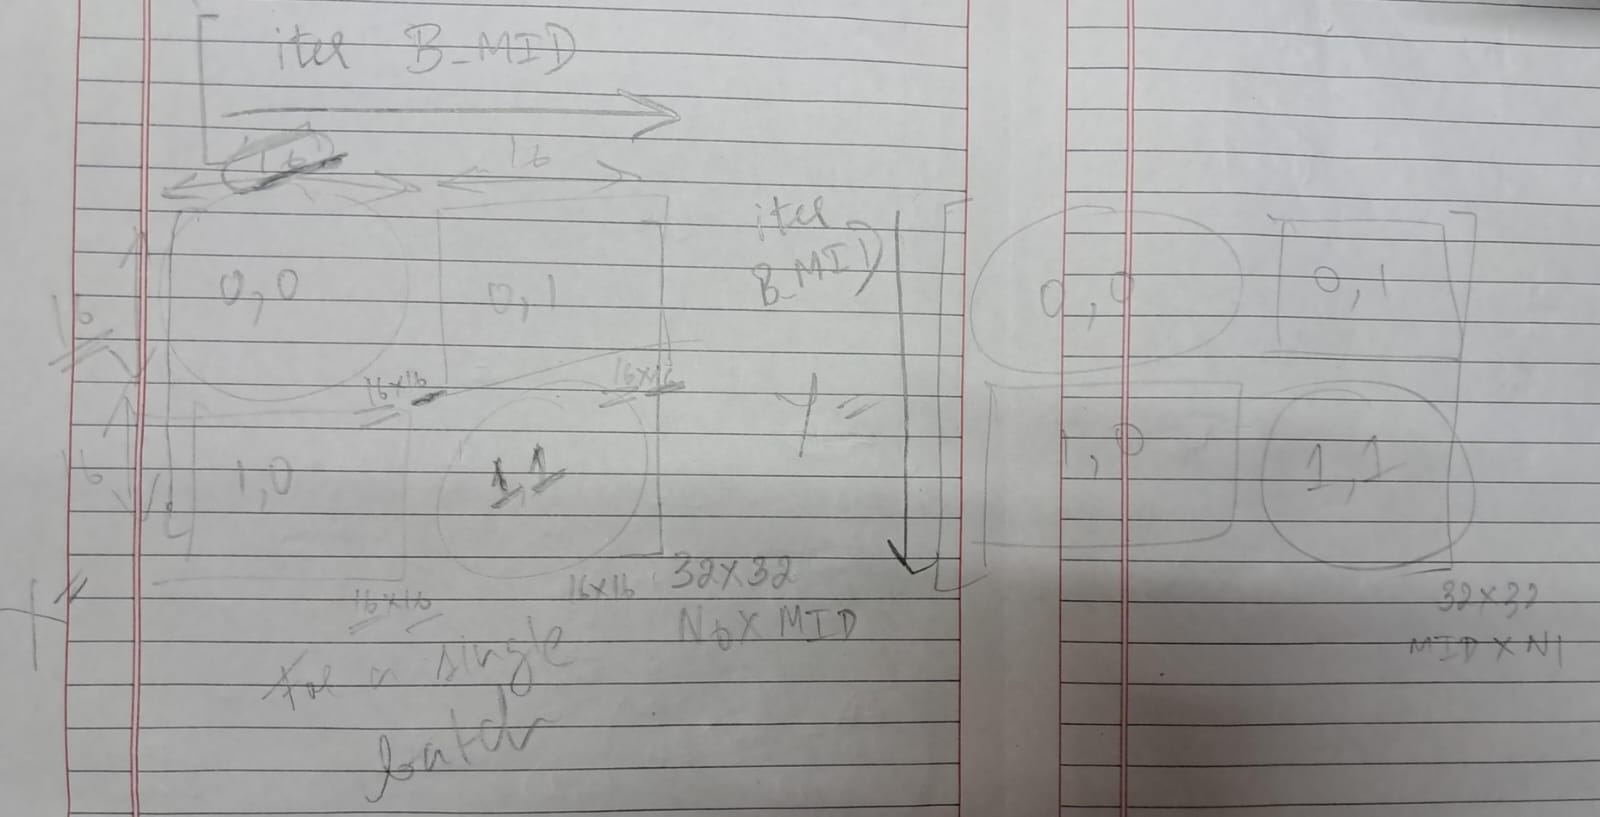

## Puzzle 12: Quantized Matrix Mult

When doing matrix multiplication with quantized neural networks a common strategy is to store the weight matrix in lower precision, with a shift and scale term.

For this problem our `weight` will be stored in 4 bits. We can store `FPINT` of these in a 32 bit integer. In addition for every `group` weights in order we will store 1 `scale` float value and 1 `shift` 4 bit value. We store these for the column of weight. The `activation`s are stored separately in standard floats.

Mathematically it looks like.

$$z_{j, k} = \sum_{l} sc_{j, \frac{l}{g}} (w_{j, l} - sh_{j, \frac{l}{g}}) \times y_{l, k} \text{ for } i = 1\ldots N_2, j = 1\ldots N_0, k = 1\ldots N_1$$

However, it is a bit more complex since we need to also extract the 4-bit values into floats to begin.




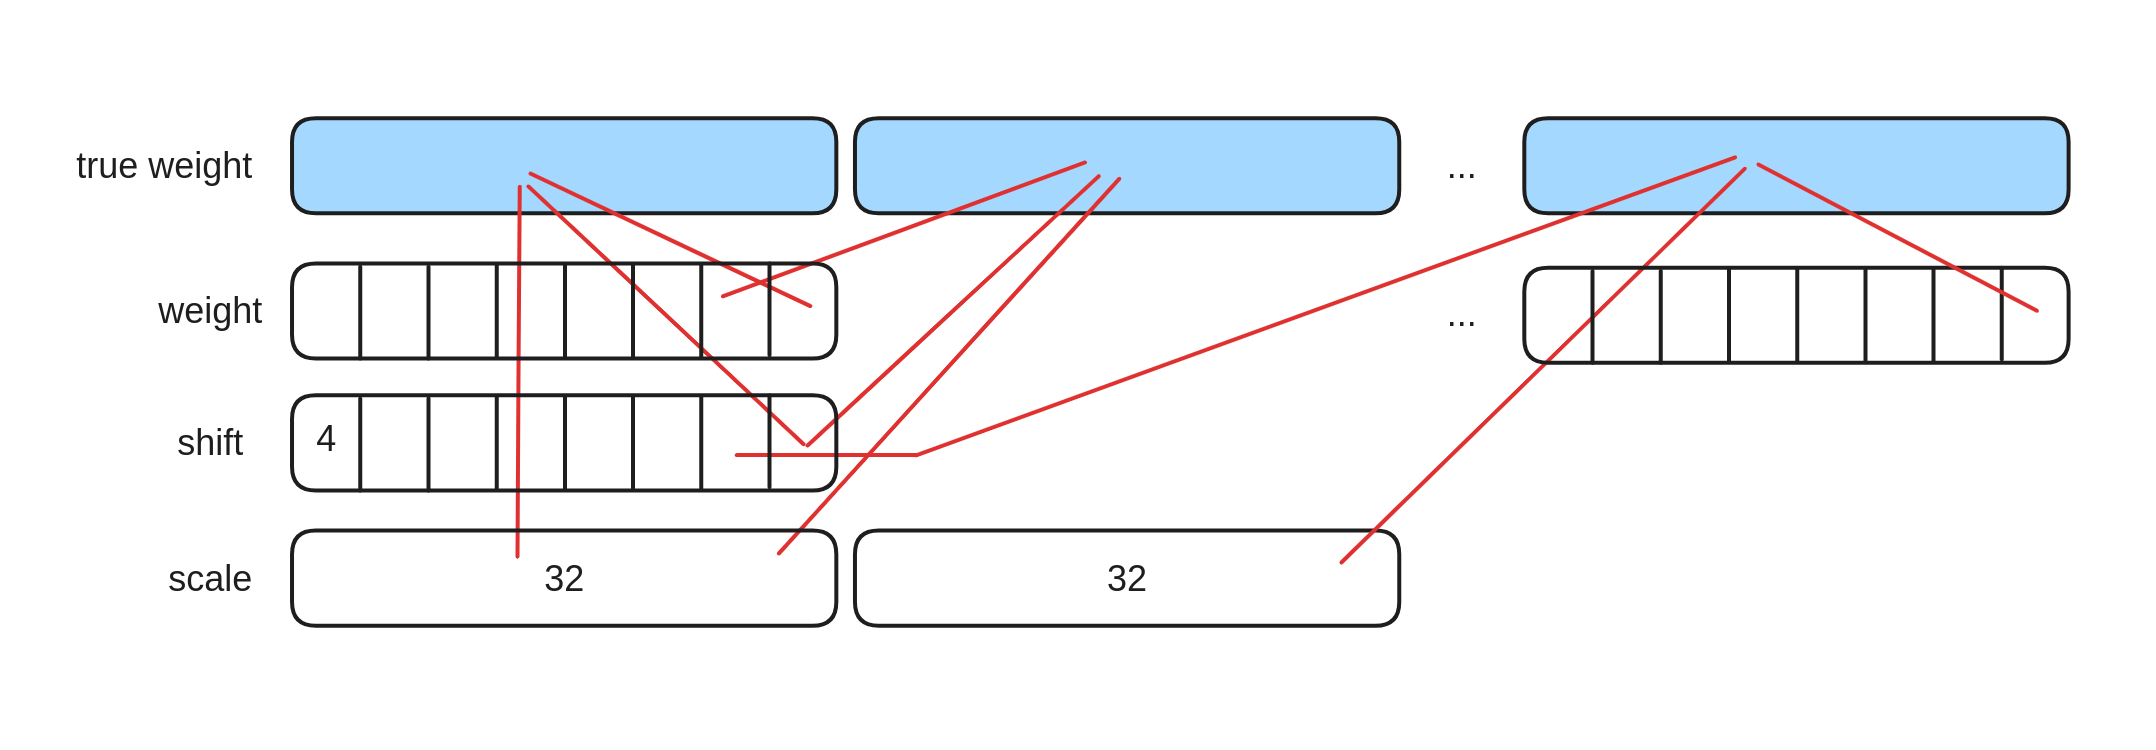

In [ ]:
torch.__version__

In [ ]:
FPINT = 32 // 4
GROUP = 8

def quant_dot_spec(scale : Float32[Tensor, "32 8"],
                   offset : Int32[Tensor, "32"],
                   weight: Int32[Tensor, "32 8"],
                   activation: Float32[Tensor, "64 32"]) -> Float32[Tensor, "32 32"]:
    offset = offset.view(32, 1)
    def extract(x):
        over = torch.arange(8) * 4
        mask = 2**4 - 1
        return (x[..., None] >> over) & mask
    scale = scale[..., None].expand(-1, 8, GROUP).contiguous().view(-1, 64)
    offset = extract(offset)[..., None].expand(-1, 1, 8, GROUP).contiguous().view(-1, 64)
    return ( scale * (extract(weight).view(-1, 64) - offset))  @ activation

@triton.jit
def quant_dot_kernel(scale_ptr, offset_ptr, weight_ptr, activation_ptr,
                     z_ptr, N0, N1, MID, B0: tl.constexpr, B1: tl.constexpr, B_MID: tl.constexpr):
    pid_0 = tl.program_id(0)
    pid_1 = tl.program_id(1)

test(quant_dot_kernel, quant_dot_spec, B={"B0": 16, "B1": 16, "B_MID": 64},
                                       nelem={"N0": 32, "N1": 32, "MID": 64})
